<a href="https://colab.research.google.com/github/charaf19/Machine_Learning/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle


In [3]:
! cp kaggle.json ~/.kaggle/


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:12<00:00, 259MB/s]
100% 2.29G/2.29G [00:12<00:00, 199MB/s]


In [6]:
! unzip chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

In [9]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [12]:
#the directory that contain the train images set
trainpath='../content/chest_xray/chest_xray/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

In [16]:
#the directory that contain the test images set
testpath='../content/chest_xray/chest_xray/test/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)


# Loading the .npy files as numpy arrays

In [17]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

In [18]:
print(loaded_X_train.shape)
#the shape return dimensions of X_train, we have 5216 images of 64 x 64 pixels. 
#while the forth dimension stores the RGB information of each pixel

(5216, 64, 64, 3)


In [19]:
print(loaded_X_test.shape)

(624, 64, 64, 3)


In [20]:
#y_train and y_test contain the labels of each image, whether 0 'NORMAL' or 1 'PNEUMONIA'
print(loaded_y_train.shape)
print(loaded_y_test.shape)

(5216,)
(624,)


#Data Analysis


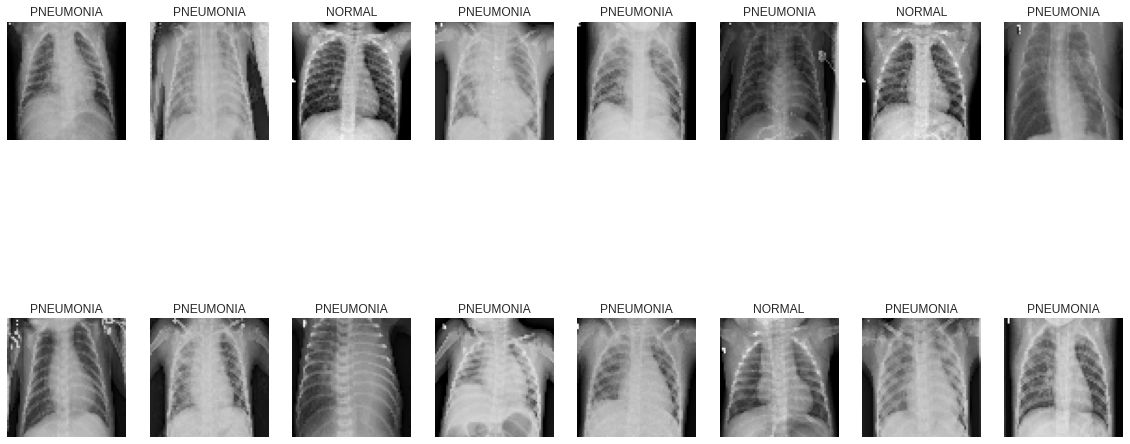

In [21]:
#plotting images of NORMAL and PNEUMONIA
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


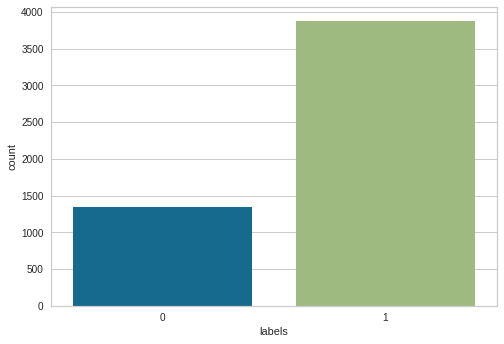

In [22]:
#count plot to show the number of pneumonia cases to normal cases in the train data set
df_train = pd.DataFrame()
df_train["labels"]= loaded_y_train
lab = df_train['labels']
dist = lab.value_counts()
sns.countplot(lab)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


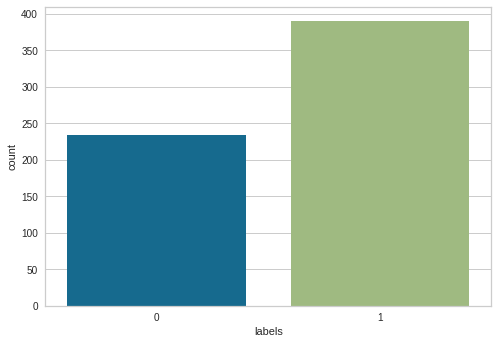

In [23]:
#count plot to show the number of pneumonia cases to normal cases in the test data set

df_test = pd.DataFrame()
df_test["labels"]= loaded_y_test
lab = df_test['labels']
dist = lab.value_counts()
#play with pallette colors
sns.countplot(lab)
plt.show()

In [24]:
#function to plot the pixel intensity of each image. 
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

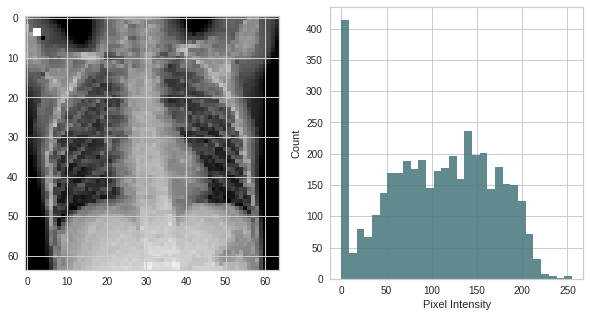

In [25]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

In [26]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [27]:
print(X_train.shape)
print(X_test.shape)

(5216, 12288)
(624, 12288)


In [28]:
y_train = loaded_y_train
y_test = loaded_y_test

In [29]:
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

#Data Preprocessing¶


In [30]:
#Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)



we will use Principle Component Analysis (PCA) to reduce the amount of features, to n number of components that represent 0.95% variance of data

In [31]:
#PCA    
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [32]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

In [33]:
print('Number of components after PCA: ' + str(pca.n_components_))

Number of components after PCA: 546


In [34]:
svm = SVC()
svm.fit(X_train, y_train)
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))
svm_predcited = svm.predict(X_test)

Support Vector Machine Classifier accuracy score is: 0.7996794871794872


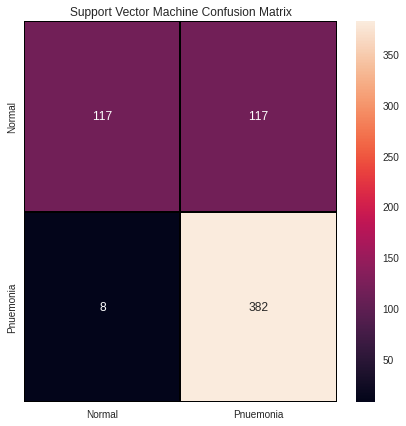

In [35]:

plot_cm(svm_predcited, y_test, 'Support Vector Machine Confusion Matrix')